In [1]:
#import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
#import the data/input file, as it contains semicoln as a delimiter we need to provide that to pandas's read_csv function

path = './tide-receipt-matching-challenge/data.csv'
data = pd.read_csv(path,delimiter=':')


In [3]:
# this is to check the size of the file, (rows, columns)
data.shape

(12034, 14)

In [4]:
# here we are checking first 5 rows to get little idea about our dataset
data.head()

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,"10,000",10000,"10,468","10,000",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"10,000",10000,"10,468","10,001",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"10,000",10000,"10,468","10,003",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"10,000",10000,"10,468","10,004",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"10,000",10000,"10,468","10,005",0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [5]:
# let's check the data types
print(data.dtypes)

receipt_id                  object
company_id                   int64
matched_transaction_id      object
feature_transaction_id      object
DateMappingMatch           float64
AmountMappingMatch         float64
DescriptionMatch           float64
DifferentPredictedTime     float64
TimeMappingMatch           float64
PredictedNameMatch         float64
ShortNameMatch             float64
DifferentPredictedDate     float64
PredictedAmountMatch       float64
PredictedTimeCloseMatch    float64
dtype: object


In [6]:
"""This is something to explore the dataset,as it's always good to have deep understanding of the dataset.
We found out that data is clean and ready to use, no missing value or outliners"""

!pip install pandas_profiling

import pandas_profiling 
pandas_profiling.ProfileReport(data)

In [7]:
#we can see in above report 5 distinct values for company_id column, so I am just checking what are these ids
data.company_id.value_counts()

30000    4926
20000    2375
10000    2351
50000    1383
40000     999
Name: company_id, dtype: int64

In [8]:
# As we have feture columns but no label in the dataset, we need to add lable by checking if matched_transaction_id and 
#feature_transaction_id are the same i.e. transaction and receipt are matching
data['receipt_match']= data.apply(lambda x: 1 if x['matched_transaction_id']== x['feature_transaction_id'] else 0, axis=1)


In [9]:
# just to confirm new column is added
data.columns

Index(['receipt_id', 'company_id', 'matched_transaction_id',
       'feature_transaction_id', 'DateMappingMatch', 'AmountMappingMatch',
       'DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch',
       'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
       'PredictedAmountMatch', 'PredictedTimeCloseMatch', 'receipt_match'],
      dtype='object')

In [10]:
#to expolre new column/label data
data.receipt_match.value_counts()

0    11177
1      857
Name: receipt_match, dtype: int64

Let's find out the features which are more correlated for our model. Though we already have some idea by df profiling we did above.
I am checking only below features as rest of the features 'receipt_id', 'company_id', 'matched_transaction_id',
'feature_transaction_id' are not actually contributing the decesion. 

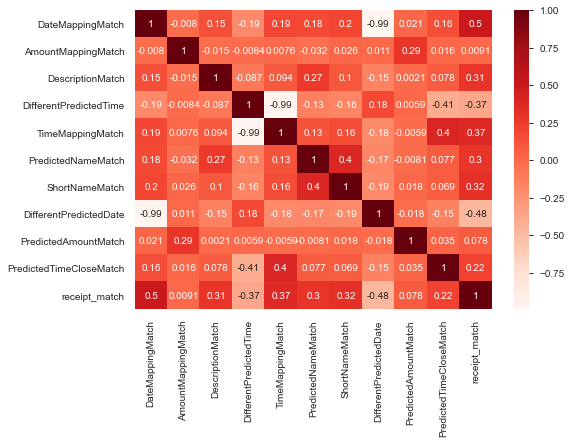

In [11]:
cor=data[['DateMappingMatch', 'AmountMappingMatch',
       'DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch',
       'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
       'PredictedAmountMatch', 'PredictedTimeCloseMatch', 'receipt_match']].corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [12]:
#Correlation with output variable
cor_target = abs(cor["receipt_match"])
#Selecting highly correlated features
relevant_features = cor_target.sort_values(ascending=False)
relevant_features

receipt_match              1.000000
DateMappingMatch           0.495295
DifferentPredictedDate     0.475173
TimeMappingMatch           0.373170
DifferentPredictedTime     0.370068
ShortNameMatch             0.324105
DescriptionMatch           0.305888
PredictedNameMatch         0.295999
PredictedTimeCloseMatch    0.216837
PredictedAmountMatch       0.077648
AmountMappingMatch         0.009137
Name: receipt_match, dtype: float64

Above corelation result surprised me, as I was expecting AmountMapping feature as a highly correlated feture. (normally if we want to match receipt and transaction first thing we will consider amount and date). But above corelation doesn't show any single feture highly corerelated (>0.5).
This is might be because of the size of the dataset. So for now I will go with all above feature though corr result shows AmountMappingMatch feature is not a great choice.

In [72]:
#check if we have any duplicate rows for positive receipt_match record in combination with receipt_id and company_id
match_data = data[data.receipt_match ==1]
duplicateRowsDF = match_data[match_data.duplicated(['receipt_id','company_id','receipt_match'])]
duplicateRowsDF

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,receipt_match


In [13]:
# Let's seperate the feature and label data (X,y)
feature_data = data[['DateMappingMatch', 'AmountMappingMatch',
       'DescriptionMatch', 'DifferentPredictedTime', 'TimeMappingMatch',
       'PredictedNameMatch', 'ShortNameMatch', 'DifferentPredictedDate',
       'PredictedAmountMatch', 'PredictedTimeCloseMatch']]

In [14]:
label_data=data[['receipt_match']]
label_data.shape

(12034, 1)

Train/Test dataset
Let's split our dataset for traing the model and then testing it on test data by using
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)


In [15]:
# first import the library and here we using test_size =0.2 means 80% data for training and 20% for testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( feature_data, label_data, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (9627, 10) (9627, 1)
Test set: (2407, 10) (2407, 1)


Modelling!!
As we have labeled data and we are trying to classify our data in given labels. We are using logistic regression model.

In [16]:
#before building model, just want to confirm our target data is integer/boolean value
label_data.dtypes

receipt_match    int64
dtype: object

In [17]:
LR = LogisticRegression().fit(X_train,y_train)
LR

/Users/supriya.khedekar/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
y_pred = LR.predict(X_test)

In [19]:
# Let's check the accuracy of the model
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(LR.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


In [20]:
#This is to check the coefficient arry for each feature we used in model
LR.coef_[0]

array([ 4.55167754,  0.37989025,  3.95896696, -1.49598152,  1.89958894,
        1.10786267,  1.888823  , -1.46164685,  2.52607593,  0.60871626])

In [21]:
# This calculates the intercept/constant of our model
LR.intercept_[0]

-4.31738135958651

In [22]:
# Check rsult details about the model by creating classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2225
           1       0.87      0.49      0.63       182

    accuracy                           0.96      2407
   macro avg       0.92      0.74      0.80      2407
weighted avg       0.95      0.96      0.95      2407



In [23]:
#Final result with intercept and feures with their coef
print("bias : ", LR.intercept_[0])

for index, feature in enumerate(feature_data.columns):
    print(feature, ' : ', LR.coef_[0][index])

bias :  -4.31738135958651
DateMappingMatch  :  4.551677539825321
AmountMappingMatch  :  0.37989024517661074
DescriptionMatch  :  3.958966961199127
DifferentPredictedTime  :  -1.4959815213430072
TimeMappingMatch  :  1.899588942795317
PredictedNameMatch  :  1.1078626669620486
ShortNameMatch  :  1.888822997478385
DifferentPredictedDate  :  -1.4616468521291772
PredictedAmountMatch  :  2.5260759264982084
PredictedTimeCloseMatch  :  0.6087162570085186


I have tried to use differnt parameters for logistic regression(random_state = 0, class_weight='balanced') and also tried different ratio 70:30 to split the data in train test model to see if we can achive better accuracy score than above.
But finally I think above model is the best we have in terms of accuracy.
By above model, the most important features are: (by order desc):
1.DateMappingMatch
2.DescriptionMatch
3.PredictedAmountMatch
4.TimeMappingMatch
5.ShortNameMatch
6.PredictedNameMatch
7.PredictedTimeCloseMatch
8.AmountMappingMatch
9.DifferentPredictedDate
10.DifferentPredictedTime